In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py 
from dedalus import public as de
from dedalus.extras import flow_tools
import time
from IPython import display
from matplotlib import animation
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal

In [3]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

## Dominio del problema

##### Cambios hechos
- El perfil de temperaturas va a ser constante, es decir se va a manter en `T0 = 20` en todo el dominio.
- Se cambia la ecuación de estado del agua por $$\rho = \rho_0 - \alpha(T-T_0) + \beta(S - S_0)$$
- 
    - Expansión térmica: $\alpha = 0.15 kg/(m^3 ºC)$
    - Salinity contraction: $\beta = 0.78 kg/(m^3 \ 1/1000)$
    

In [4]:
Lx, Ly = (0.2, 0.35)
nx, ny = (256, 256)
#Prandtl = 1.
#Rayleigh = 5.8e7

ν = 1.8e-6 # m^2/s viscocidad cinemática
k = 2e-5 # s^-1 
T0 = 20.0 # ºC Promedio de las temperaturas iniciales
T_b = 24.0 #Bottom temperature ºC
g = 9.8 #  m/s^2
κ = 1.3e-7 #thermal difussivity m^2/s
ρ0 = 1007.5 # kg/m^3 promedio de las densidades iniciales
α = 0.15 # kg/m^3ºC thermal expansion
β = 0.78 # kg/m^3%0 salinity contraction
s_top = 0. #salinidad top (partes por mil)
s_bot = 12.5 #salinidad bottom (partes por mil)
s0 = 9.4727

T_air = 20. # ºC temperatura de aire.
T_top = 20.0
z_int = 0.18
L_conv = 0.35
Reynolds = 100
Schmidt = 1

x_basis = de.Fourier('x', nx, interval=(0, Lx))
y_basis = de.Chebyshev('y', ny, interval=(0, Ly))
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

## Ecuaciones

In [5]:
problem = de.IVP(domain, variables=['p', 'u', 'v', 'ρ', 's', 'T', 'uy', 'vy', 'Ty', 'sy'])

In [6]:
problem.meta['p', 'T', 'u', 'v', 'ρ', 's']['y']['dirichlet'] = True

In [7]:
#problem.parameters['P'] = (Rayleigh * Prandtl)**(-1/2)
#problem.parameters['R'] = (Rayleigh / Prandtl)**(-1/2)
#problem.parameters['F'] = F = 1
problem.parameters['ν'] = ν
problem.parameters['κ'] = κ
problem.parameters['T_air'] = T_air
problem.parameters['k'] = k 
problem.parameters['ρ0'] = ρ0
problem.parameters['T_0'] = T0 #4.0 ºC
problem.parameters['g'] = 9.8
problem.parameters['α'] = α
problem.parameters['β'] = β
problem.parameters['T_b'] = T_b
problem.parameters['T_top'] = T_top
problem.parameters['s0'] = s0
problem.parameters['s_top'] = s_top
problem.parameters['s_bot'] = s_bot
problem.parameters['Lx'] = Lx

problem.parameters['Re'] = Reynolds
problem.parameters['Sc'] = Schmidt

problem.add_equation("dx(u) + vy = 0") #continuidad
problem.add_equation("dt(u) - ν*(dx(dx(u)) + dy(uy)) + dx(p) = -(u*dx(u) + v*uy)") #N-S x
problem.add_equation("dt(v) - ν*(dx(dx(v)) + dy(vy)) + dy(p) = -(u*dx(v) + v*vy) + g*(ρ - ρ0)/ρ0") #N-S y
problem.add_equation("dt(T) - κ*(dx(dx(T)) + dy(Ty)) = - u*dx(T) - v*Ty - k*(T - T_air)") #conservación energía
problem.add_equation("ρ = ρ0 - α*(T - T_0) + β*(s - s0)") #ecuación de estado
problem.add_equation("dt(s) - 1/(Re)*(dx(dx(s)) + dy(sy)) = - u*dx(s) - v*sy") #ecuación para salinidad
#Nota: quité el número de Schmidt

problem.add_equation("Ty - dy(T) = 0")
problem.add_equation("uy - dy(u) = 0")
problem.add_equation("vy - dy(v) = 0")
problem.add_equation("sy - dy(s) = 0")

problem.add_bc("left(T) = T_b")
problem.add_bc("right(T) = T_top")

problem.add_bc("left(u) = 0")
problem.add_bc("right(u) = 0")

problem.add_bc("left(v) = 0")
problem.add_bc("right(v) = 0", condition="(nx != 0)")

problem.add_bc("left(s) = s_bot")
problem.add_bc("right(s) = s_top")

problem.add_bc("right(p) = 0", condition="(nx == 0)")

## Condiciones de frontera

In [8]:
solver = problem.build_solver(de.timesteppers.RK222)

2017-09-24 21:18:54,934 pencil 0/1 INFO :: Building pencil matrix 1/128 (~1%) Elapsed: 0s, Remaining: 23s, Rate: 5.5e+00/s
2017-09-24 21:18:56,818 pencil 0/1 INFO :: Building pencil matrix 13/128 (~10%) Elapsed: 2s, Remaining: 18s, Rate: 6.3e+00/s
2017-09-24 21:18:58,819 pencil 0/1 INFO :: Building pencil matrix 26/128 (~20%) Elapsed: 4s, Remaining: 16s, Rate: 6.4e+00/s
2017-09-24 21:19:00,803 pencil 0/1 INFO :: Building pencil matrix 39/128 (~30%) Elapsed: 6s, Remaining: 14s, Rate: 6.4e+00/s
2017-09-24 21:19:02,748 pencil 0/1 INFO :: Building pencil matrix 52/128 (~41%) Elapsed: 8s, Remaining: 12s, Rate: 6.5e+00/s
2017-09-24 21:19:04,757 pencil 0/1 INFO :: Building pencil matrix 65/128 (~51%) Elapsed: 10s, Remaining: 10s, Rate: 6.5e+00/s
2017-09-24 21:19:07,014 pencil 0/1 INFO :: Building pencil matrix 78/128 (~61%) Elapsed: 12s, Remaining: 8s, Rate: 6.4e+00/s
2017-09-24 21:19:08,978 pencil 0/1 INFO :: Building pencil matrix 91/128 (~71%) Elapsed: 14s, Remaining: 6s, Rate: 6.4e+00/s
2

## Condiciones iniciales

In [9]:
x = domain.grid(0)
y = domain.grid(1)
T = solver.state['T']
Ty = solver.state['Ty']
ρ = solver.state['ρ']
s = solver.state['s']

#### Perfil de temepratura lineal

In [10]:
def perfil_arriba(x):
    return -12.5/(0.35 - 0.18)*x - -12.5/(0.35 - 0.18)*0.35

In [11]:
yb, yt = y_basis.interval

In [12]:
yt

0.35

In [13]:
x = domain.grid(0,scales=domain.dealias)
y = domain.grid(1,scales=domain.dealias)
xm, ym = np.meshgrid(x,y)

In [14]:
y.shape

(1, 256)

In [15]:
T['g'].shape

(256, 256)

In [16]:
y_t, y_b = y_basis.interval

In [17]:
a, b = T['g'].shape
pert =  np.random.rand(a,b) * (yt - y) * (y - 0.18) * y * (y - 0.26) * 1000

In [18]:
T['g'] = np.zeros_like(y) + 20. + pert


In [19]:
T['g'] = np.zeros_like(y) + 20. + 100* np.random.rand(256, 256) * (y_t - y) * (y - y_b) * (0.18 - y) * (0.26 - y)*(0.23 - y)*(0.29 - y)
#s['g'] = perfil_arriba(y)

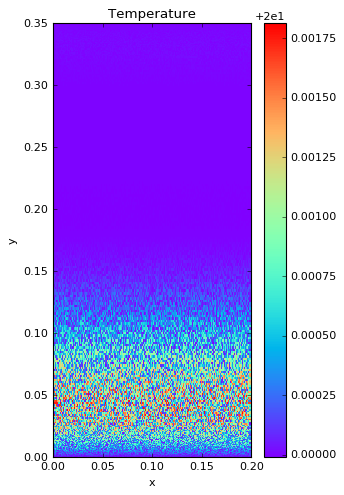

In [20]:
fig, axis = plt.subplots(figsize=(4,7))
pT = axis.pcolormesh(xm, ym, T['g'].T, cmap='rainbow');
plt.colorbar(pT)
plt.title('Temperature')
plt.xlabel('x')
plt.ylabel('y')

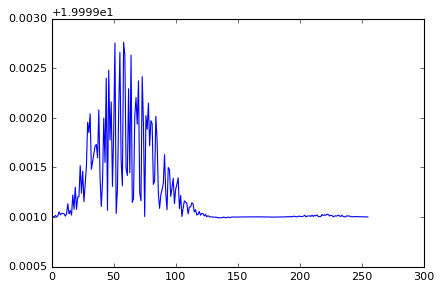

In [21]:
plt.plot(T['g'][2])

In [22]:
range(0, len(y[0]))

range(0, 256)

In [23]:
for i in range(0, len(y[0])):
    if y[0, i] <= 0.18:
        s['g'][:, i] = s_bot
    elif y[0,i] > 0.18:
        s['g'][:, i] = perfil_arriba(y[0,i])


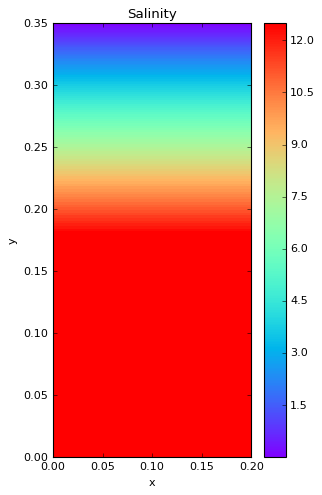

In [24]:
fig, axis = plt.subplots(figsize=(4,7))
pT = axis.pcolormesh(xm, ym, s['g'].T, cmap='rainbow');
plt.colorbar(pT)
plt.title('Salinity')
plt.xlabel('x')
plt.ylabel('y')

In [25]:
ρ['g'] = ρ0 - α*(T['g'] - T0) + β*(s['g'] - s0)

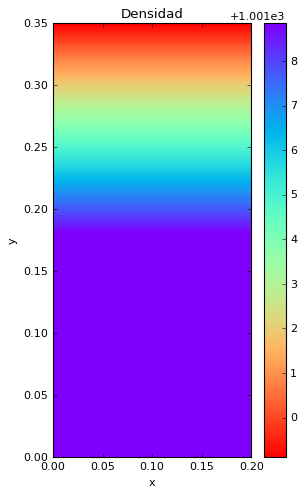

In [26]:
fig, axis = plt.subplots(figsize=(4,7))
pT = axis.pcolormesh(xm, ym, ρ['g'].T,  cmap='rainbow_r');
plt.colorbar(pT)
plt.title('Densidad')
plt.xlabel('x')
plt.ylabel('y')

In [27]:
sum(ρ['g'][5,:])/256

1006.8085429970397

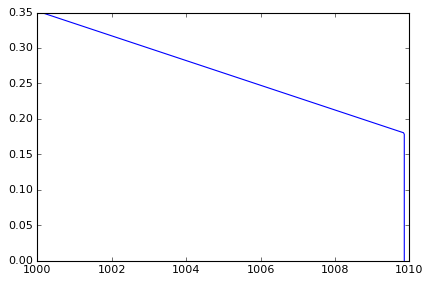

In [28]:
plt.plot(ρ['g'][5,:], y[0])

In [29]:
# Initial timestep
dt = 0.02
# Integration parameters
solver.stop_sim_time = 10
solver.stop_wall_time = 30 * 90.
solver.stop_iteration = np.inf

# Analysis
snapshots = solver.evaluator.add_file_handler('strat_andrea', sim_dt=0.25, max_writes=100)
snapshots.add_system(solver.state)
#solver.evaluator.vars['Lx'] = Lx
snapshots.add_task("integ(s,'x')/Lx", name='s profile')
snapshots.add_task("integ(T,'x')/Lx", name='T profile')


# CFL
CFL = flow_tools.CFL(solver, initial_dt=dt, cadence=5, safety=0.1, max_change=1.5, min_change=0.5, max_dt=0.02, threshold=0.01)
CFL.add_velocities(('u', 'v'))


In [30]:
try:
    logger.info('Starting loop')
    start_time = time.time()
    while solver.ok:
        #print("hola")
        dt = CFL.compute_dt()
        dt = solver.step(dt)
        if (solver.iteration-1) % 10 == 0:
            # Update plot of scalar field
            logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
            #logger.info('Max Re = %f' %flow.max('Re'))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    end_time = time.time()
    logger.info('Iterations: %i' %solver.iteration)
    logger.info('Sim end time: %f' %solver.sim_time)
    logger.info('Run time: %.2f sec' %(end_time-start_time))
    logger.info('Run time: %f cpu-hr' %((end_time-start_time)/60/60*domain.dist.comm_cart.size))

2017-09-24 21:20:11,102 __main__ 0/1 INFO :: Starting loop
2017-09-24 21:20:15,264 __main__ 0/1 INFO :: Iteration: 1, Time: 2.000000e-02, dt: 2.000000e-02
2017-09-24 21:20:44,349 __main__ 0/1 INFO :: Iteration: 11, Time: 2.200000e-01, dt: 2.000000e-02
2017-09-24 21:21:16,208 __main__ 0/1 INFO :: Iteration: 21, Time: 4.200000e-01, dt: 2.000000e-02
2017-09-24 21:21:45,581 __main__ 0/1 INFO :: Iteration: 31, Time: 6.200000e-01, dt: 2.000000e-02
2017-09-24 21:22:14,699 __main__ 0/1 INFO :: Iteration: 41, Time: 8.200000e-01, dt: 2.000000e-02
2017-09-24 21:22:43,804 __main__ 0/1 INFO :: Iteration: 51, Time: 1.020000e+00, dt: 2.000000e-02
2017-09-24 21:23:12,696 __main__ 0/1 INFO :: Iteration: 61, Time: 1.220000e+00, dt: 2.000000e-02
2017-09-24 21:23:41,560 __main__ 0/1 INFO :: Iteration: 71, Time: 1.420000e+00, dt: 2.000000e-02
2017-09-24 21:24:10,870 __main__ 0/1 INFO :: Iteration: 81, Time: 1.620000e+00, dt: 2.000000e-02
2017-09-24 21:24:40,185 __main__ 0/1 INFO :: Iteration: 91, Time: 1.8

# Análisis de datos

In [35]:
def extraer_datos(nombre_h5):

    with h5py.File(nombre_h5, flag ='r') as hdf:
        base_items = list(hdf.items())
        print(base_items, '\n')
        tasks = hdf.get('tasks')
        tasks_items = list(tasks.items())
        print(tasks_items)

        T = np.array(tasks.get('T'))
        print(T.shape)

        ρ = np.array(tasks.get('ρ'))
        print(ρ.shape)
        
        s = np.array(tasks.get('s'))
        print(s.shape)
        
        s_avg = np.array(tasks.get('s profile'))
        print(s_avg.shape)
        
        T_avg = np.array(tasks.get('T profile'))
        print(T_avg.shape)
        
    return T, ρ, s, s_avg, T_avg

In [37]:
T_dat , ρ_dat, s_dat, s_avg, T_avg = extraer_datos('strat_andrea/strat_andrea_s1/strat_andrea_s1_p0.h5')

[('scales', <HDF5 group "/scales" (10 members)>), ('tasks', <HDF5 group "/tasks" (12 members)>)] 

[('T profile', <HDF5 dataset "T profile": shape (18, 1, 256), type "<f8">), ('vy', <HDF5 dataset "vy": shape (18, 256, 256), type "<f8">), ('s profile', <HDF5 dataset "s profile": shape (18, 1, 256), type "<f8">), ('p', <HDF5 dataset "p": shape (18, 256, 256), type "<f8">), ('uy', <HDF5 dataset "uy": shape (18, 256, 256), type "<f8">), ('T', <HDF5 dataset "T": shape (18, 256, 256), type "<f8">), ('ρ', <HDF5 dataset "ρ": shape (18, 256, 256), type "<f8">), ('u', <HDF5 dataset "u": shape (18, 256, 256), type "<f8">), ('s', <HDF5 dataset "s": shape (18, 256, 256), type "<f8">), ('sy', <HDF5 dataset "sy": shape (18, 256, 256), type "<f8">), ('v', <HDF5 dataset "v": shape (18, 256, 256), type "<f8">), ('Ty', <HDF5 dataset "Ty": shape (18, 256, 256), type "<f8">)]
(18, 256, 256)
(18, 256, 256)
(18, 256, 256)
(18, 1, 256)
(18, 1, 256)


In [38]:
s_dat.shape

(18, 256, 256)

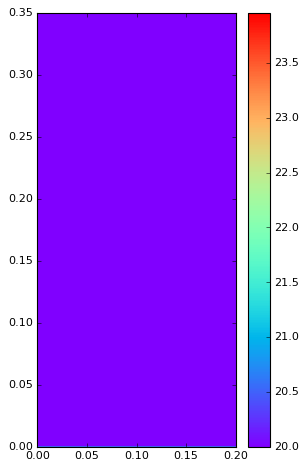

In [41]:
fig, axis = plt.subplots(figsize=(4,7))
p = axis.pcolormesh(xm, ym, T_dat[1].T, cmap='rainbow');
plt.colorbar(p)

In [49]:
s_avg[0][0].shape

(256,)

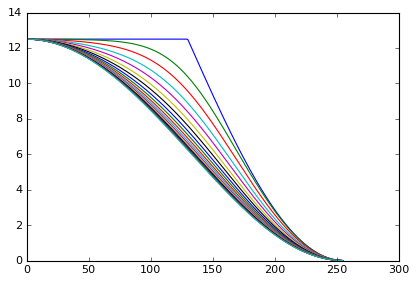

In [51]:
for i in range(0,18):
    plt.plot(s_avg[i][0])

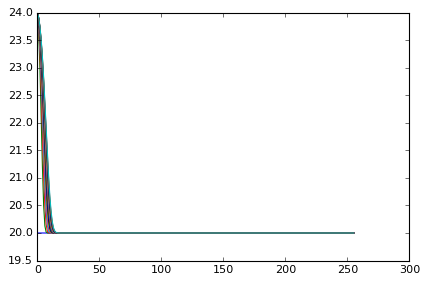

In [57]:
for i in range(0,18):
    plt.plot(T_avg[i][0])
    
#plt.xlim(0,20)

In [40]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [47]:
np.min(T_dat[0])

19.952810910893064

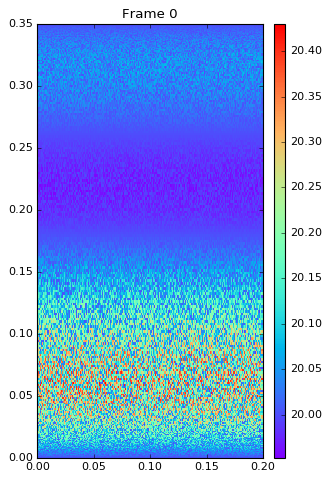

In [45]:
fig = plt.figure(figsize=(4,7))
ax = fig.add_subplot(111)
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
cv0 = T_dat[0].T
im = ax.pcolormesh(xm, ym, cv0, cmap='rainbow') # Here make an AxesImage rather than contour
cb = fig.colorbar(im, cax=cax)
tx = ax.set_title('Frame 0')


In [43]:
def f(x, y):
    return np.exp(x) + np.sin(y)

x = np.linspace(0, 1, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)


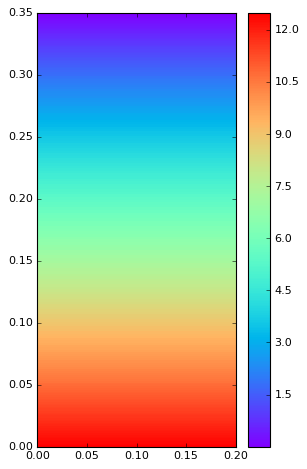

In [95]:
fig, axis = plt.subplots(figsize=(4,7))
p = axis.pcolormesh(xm, ym, s_dat[39].T, cmap='rainbow');
plt.colorbar(p)